<img src=../figures/Brown_logo.svg width=50%>

## Data-Driven Design & Analyses of Structures & Materials (3dasm)

## Lecture Markov Chain Monte Carlo

### Miguel A. Bessa | <a href = "mailto: miguel_bessa@brown.edu">miguel_bessa@brown.edu</a>  | Associate Professor

## Outline for today

* How to interpret Bayesian neural network compared to deterministic NN?
* How to integrate the posterior through Markov Chain Monte Carlo (MCMC)?


**Reading material**: This notebook + (Murphy's advanced book, chapter Part II Inference)

## Recap: ANN for regression with Gaussian prior
<img align=right src="./figures/recap.png" width=40%>


Assume a Gaussian prior  $\require{color} \color{red}p(z)$ on $\mathbf{w}$ and the MAP point estimate for an DNN

$$\require{color}
\hat{\mathbf{z}}_{\text{map}} = \underset{z}{\mathrm{argmin}}\left[-\log{p(\mathbf{y}=\mathbf{y}_n|\mathbf{x}=\mathbf{x}_n, \mathbf{z})} - \log{{\color{red}p(z)}}\right]$$


Performing the calculation, the point estimate when assuming a Gaussian prior becomes:

$$
\begin{align}
\hat{\mathbf{z}}_{\text{map}} = \underset{z}{\mathrm{argmin}}\left[\frac{1}{2} ||\mathbf{Y}-\mathbf{f}(\mathbf{X},\mathbf{z}) ||_2^2 + \alpha ||\mathbf{w}||_2^2\right]
\end{align}
$$

**Then, we can use sophisticated optimizers, as introduced in notebooks 25,26,27, for exploring the loss landscape (the right figure) to get a point estimation.**

## What if we want to get the posterior distributon of weights?

- Conceptually, from point estmation (DNN) to posterior distribution (BNN), we can inprepret we change the likelihood and prior from delta distribution to another distributions, like Gaussian distribution. 

 <img align=center src="./figures/dnnbnn.png" width=60%>


## What if we want to get the posterior distributon of weights?

- From an optimization view, instead of obtaining an optimum (shown in the left figure), it requires to integrate the whole loss (posterior distribution) landscape, as indicated in the second figure. 

 <img align=center src="./figures/OPTIMIZATION_VS_INFERENCE.png" width=60%>

## We then can formulate posterior with Bayes' rule?

\begin{align}
p\left( \mathbf{z} \mid \mathcal{D} \right) = \frac{p\left( \mathcal{D} \mid \mathbf{z} \right) p\left( \mathbf{z} \right)}{p\left( \mathcal{D} \right)} \propto p\left( \mathcal{D} \mid \mathbf{z} \right) \, p\left( \mathbf{z} \right)
\end{align}

- Likelihood: $
p\left( \mathcal{D} \mid \mathbf{z} \right)
= \mathcal{N}\!\left( \mathbf{Y} \,\middle|\, \mathbf{f}(\mathbf{X}, \mathbf{z}), \, \sigma^2 \mathbf{I} \right)
$, where $\sigma^2$ is the data noise.
- Prior:$
p\left( \mathbf{z} \right)
= \mathcal{N}\!\left( \mathbf{z} \,\middle|\, \mathbf{0}, \, \tau^2 \mathbf{I} \right)
$, where $\tau^2$ the variance of prior distribution.
- Log posterior can be derivated by:

\begin{align}
\log p\left( \mathbf{z} \mid \mathcal{D} \right) &= \log p\left( \mathcal{D} \mid \mathbf{z} \right) + \log p\left( \mathbf{z} \right)\\
&= \log \left[ \frac{\exp\left( -\frac{1}{2\sigma^2} 
    \left\| \mathbf{Y} - \mathbf{f}(\mathbf{X}, \mathbf{z}) \right\|_2^2 \right) }{(2\pi\sigma^2)^{n/2}} 
    \right]  + \log \left[ \frac{ \exp\left( -\frac{1}{2\tau^2} 
    \left\| \mathbf{w} \right\|_2^2 \right) }{(2\pi\tau^2)^{m/2}} \right] \\
&= -\frac{n}{2} \log(2\pi\sigma^2) 
   -\frac{1}{2\sigma^2} \left\| \mathbf{Y} - \mathbf{f}(\mathbf{X}, \mathbf{z}) \right\|_2^2  -\frac{m}{2} \log(2\pi\tau^2) 
   -\frac{1}{2\tau^2} \left\| \mathbf{w} \right\|_2^2
\end{align}

where $\frac{1}{2\tau^2}$ corresponds to the weight decay $\alpha$ in a deterministic setting

## How to integrate the posterior distribution? 

- The process of computing the posterior distribution over these variables based on observed data, following Bayes’ rule, is referred to as *inference*. 


- Once the likelihood, prior, and training data are fixed, the posterior distribution is also determined.


- On the other hand, changing any hyperparameter—such as replacing a Gaussian likelihood with another distribution or altering the data noise $\sigma^2$—will modify the posterior distribution. It is a higher-level Bayesian model training see Lecture 16.





### Markov Chain Monte Carlo (MCMC)


- A stochastic sampling method that constructs a Markov chain whose stationary distribution matches the target distribution $ p(\boldsymbol{\theta}) $. In the case of BNN, it is $p(\mathbf{z}|\mathcal{D})$.  
- It starts from an initial position $\boldsymbol{\theta}_0$ and generates candidate samples using a proposal distribution $ q(\boldsymbol{\theta}' \mid \boldsymbol{\theta}) $.  
- Each candidate is either accepted or rejected based on an acceptance rule (e.g., Metropolis–Hastings criterion), ensuring the chain explores the state space.  
- **Theoretical guarantee:** Under mild conditions (irreducibility, aperiodicity, detailed balance), the Markov chain converges to the target distribution as the number of iterations goes to infinity.  

 <img align=center src="./figures/ilustration_of_mcmc.png" width=30%> 



In [1]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torch.autograd import grad
class TargetDistribution:
    def __init__(self,  w1=0.3, w2=0.7, mu1=-2.0, sigma1=1.0, mu2=2.0, sigma2=1.0,):
        self.w1 = w1
        self.w2 = w2
        # Parameters as tensors (for autograd + device support)
        self.mu1 = torch.tensor(mu1, dtype=torch.float32)
        self.sigma1 = torch.tensor(sigma1, dtype=torch.float32)
        self.mu2 = torch.tensor(mu2, dtype=torch.float32)
        self.sigma2 = torch.tensor(sigma2, dtype=torch.float32)
        self.pi = torch.tensor(torch.pi, dtype=torch.float32)

    def gaussian(self, x, mu, sigma):
        coef = 1.0 / (sigma * torch.sqrt(2 * self.pi))
        exponent = -0.5 * ((x - mu) / sigma) ** 2
        return coef * torch.exp(exponent)

    def pdf(self, x):
        return self.w1 * self.gaussian(x, self.mu1, self.sigma1) + \
               self.w2 * self.gaussian(x, self.mu2, self.sigma2)

    def plot_pdf(self, range_x=(-8, 8), num_points=1000):
        x = torch.linspace(range_x[0], range_x[1], num_points)
        y = self.pdf(x)
        plt.figure(figsize=(5, 4))
        plt.plot(x, y, label='Target PDF')
        plt.xlabel('x'); plt.ylabel('pdf')
        plt.legend()
        plt.tight_layout()
        plt.show()

    

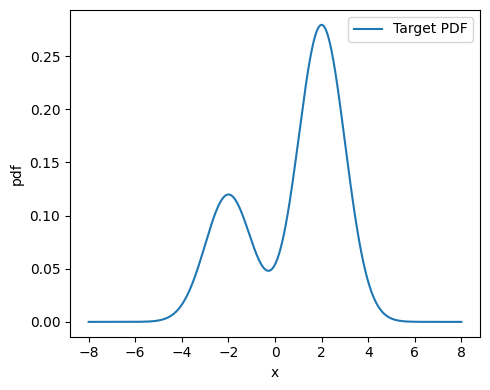

In [2]:
target  = TargetDistribution()

target.plot_pdf()

In [3]:
class MetropolisHastings:
    def __init__(self, target_distribution, num_samples=2000, burn_in=200, step_size=1.0):
        self.target_distribution = target_distribution #target pdf
        self.num_samples = num_samples # how many samples to be sampled
        self.burn_in = burn_in # burn in step
        self.step_size = step_size # step size of sampling

    def run(self, num_trials=1, x0=None):
        self.trial_samples, self.acceptance_rate = [], []
        for trial in range(num_trials):
            x = torch.randn(()) if x0 is None else torch.as_tensor(x0).reshape(())
            samples, accepts = [], 0 # initiate the samples and acceptance ratio
            for i in range(self.num_samples + self.burn_in):
                proposed_x = x + torch.randn(()) * self.step_size
                p_prop = self.target_distribution.pdf(proposed_x)
                p_curr = self.target_distribution.pdf(x)
                log_alpha = torch.log(p_prop + 1e-12) - torch.log(p_curr + 1e-12)
                if torch.log(torch.rand(())) < torch.minimum(torch.tensor(0.), log_alpha):
                    x = proposed_x
                    accepts += 1
                if i >= self.burn_in:
                    samples.append(x.item())
            rate = accepts / self.num_samples
            print(f'Acceptance rate of trial {trial}: {rate:.4f}')
            self.acceptance_rate.append(rate)
            self.trial_samples.append(torch.tensor(samples))
        return self.trial_samples

    def plot_trials(self, bins=30, x_range=(-10, 10), num_points=1000):
        fig, ax = plt.subplots(figsize=(5, 4))
        for i, samples in enumerate(self.trial_samples):
            ax.hist(samples.numpy(), bins=bins, density=True, alpha=0.6, label=f'Trial {i+1}')
        x = torch.linspace(*x_range, num_points)
        ax.plot(x.numpy(), self.target_distribution.pdf(x).numpy(), 'r--', label='Target PDF')
        ax.legend()
        ax.set_xlabel('x'); ax.set_ylabel('Density')
        plt.tight_layout(); plt.show()

Acceptance rate of trial 0: 0.4040
Acceptance rate of trial 1: 0.3770
Acceptance rate of trial 2: 0.3700
Acceptance rate of trial 3: 0.3695
Acceptance rate of trial 4: 0.3690


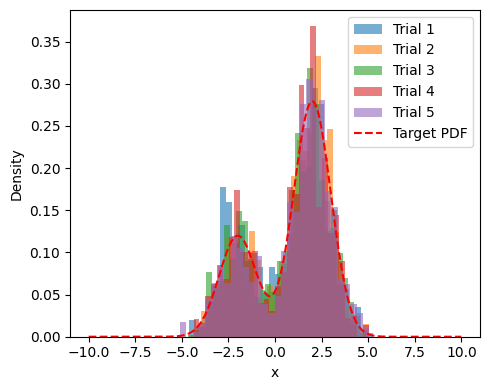

In [4]:
# play with burn_in, step_size, number_samples of RWMH method, which are the tunable parameters of RWMH
MH = MetropolisHastings(target_distribution=target,
                        num_samples=2000, 
                        burn_in=10, 
                        step_size=5.0)
# run 5 times the samples
results = MH.run(num_trials=5)
# plot the sampled pdf with the true one
MH.plot_trials()


## Hamiltonian Monte Carlo (HMC)
- One fatal drawback of RWMH algorithm is that the random walk procedure prevents the scalability.

- Hamiltonian Monte Carlo (Neal 2012) improves the convergence, with embedding the concept of Hamitonian mechanics. 



<img src="figures/hmc.png" title="Hamiltonian mechanics" width="30%" align="right">
<!-- <img align=center src="./figures/hmc.png" width=20%>  -->
A Hamiltonian mechanical system can be imagined as a ball rolling in a frictionless bowl:
$$
\mathcal{H}\left(\boldsymbol{\theta}, \mathrm{v} \right) =
   \mathcal{\varepsilon(\boldsymbol{\theta})} + \mathcal{K}(\mathrm{v})
$$

- potential energy: $\mathcal{\varepsilon(\boldsymbol{\theta})} = - \log \, p(\boldsymbol{\theta})$

- kinetic energy: $\mathcal{K}(\mathrm{v}) = \frac{1}{2}\mathrm{v}^{T} {\Sigma}^{-1} \mathrm{v}$

where ${\Sigma}$ is the mass matrix.

**Key Idea**
- Uses Hamiltonian dynamics to propose new states by simulating trajectories shown in the figure
- **Efficiently explores** the target distribution by following energy-preserving paths.



### How to update position and velocity within Hamiltonian system: 

- **Euler's method**

$$\mathrm{v}_{t+1} = \mathrm{v}_{t} + \eta \frac{d\mathrm{v}(\mathrm{\theta}_t, \mathrm{v}_t)}{dt}= \mathrm{v}_{t}-\eta \frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_t)}{\partial \mathrm{\theta}} $$

$$\mathrm{\theta}_{t+1} = \mathrm{\theta}_{t} + \eta \frac{d\mathrm{\theta}(\mathrm{\theta}_t, \mathrm{v}_t)}{dt}= \mathrm{\theta}_{t}-\eta \frac{\partial \mathcal{K}(\mathrm{v}_t)}{\partial \mathrm{v}}$$

- **Modified Euler's method: _Improve accuracy_**

$$\mathrm{v}_{t+1} = \mathrm{v}_{t} + \eta \frac{d\mathrm{v}(\mathrm{\theta}_t, \mathrm{v}_t)}{dt}= \mathrm{v}_{t}-\eta \frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_t)}{\partial \mathrm{\theta}} $$

$$\mathrm{\theta}_{t+1} = \mathrm{\theta}_{t} + \eta \frac{d\mathrm{\theta}(\mathrm{\theta}_t, \mathrm{v}_{t+1})}{dt}= \mathrm{\theta}_{t}-\eta \frac{\partial \mathcal{K}(\mathrm{v}_{t+1})}{\partial \mathrm{v}}$$


### How to update position and velocity within Hamiltonian system: 

- **Leapfrog method:** *further improve the accuracy, with multiple leapfrog steps update*

$$\mathrm{v}_{t+\frac{1}{2}} =\mathrm{v}_{t}-\frac{\eta }{2}\frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_t)}{\partial \mathrm{\theta}} $$

$$\mathrm{\theta}_{t+1} =  \mathrm{\theta}_{t}+\eta \frac{\partial \mathcal{K}(\mathrm{v}_{t+\frac{1}{2}})}{\partial \mathrm{v}}$$

$$\mathrm{v}_{t+1} =\mathrm{v}_{t+\frac{1}{2}}-\frac{\eta }{2}\frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_{t+1})}{\partial \mathrm{\theta}} $$

In [5]:
class HMC:
    def __init__(self,
                 neg_log_prob,
                 num_dim,
                 step_size=0.1,
                 leapfrog_steps=10,
                 num_samples=100,
                 burn_in=10,
                 device='cpu'):
    
        self.neg_log_prob = neg_log_prob
        self.step_size = step_size
        self.leapfrog_steps = leapfrog_steps
        self.num_samples = num_samples
        self.burn_in = burn_in
        self.device = device
        self.num_dim = num_dim

    def potential_energy(self, x):
        """ calculate the potential energy, i.e., negative log likelihood
        """
        return self.neg_log_prob(x)

    def kinetic_energy(self, p):
        """calculate the kinetic energy of the system, assuming unit mass.
        """
        return 0.5 * torch.sum(p ** 2)

    def grad_potential_energy(self, x):
        """calculate the gradient of the potential energy using autograd.
        """
        x = x.clone().detach().requires_grad_(True)
        U = self.potential_energy(x)
        grad_U = grad(U, x, create_graph=False)[0]
        return grad_U

    def leapfrog(self, x, p):
        # get the initial position and momentum
        x = x.clone()
        p = p.clone()
        # update half step for momentum
        p -= 0.5 * self.step_size * self.grad_potential_energy(x)
        # perform leapfrog steps
        for i in range(self.leapfrog_steps):
            # a full step for position
            x += self.step_size * p
            if i != self.leapfrog_steps - 1:
                # a full step for momentum
                p -= self.step_size * self.grad_potential_energy(x)
        # update the momentum for the last step
        p -= 0.5 * self.step_size * self.grad_potential_energy(x)
        return x, -p

    def sample(self, init_position: torch.Tensor = None):
        """Sample from the posterior distribution using Hamiltonian Monte Carlo.
        """
        self.chain_nll= []
        self.chain_samples = []
        samples = []
        accept_count = 0
        # get initial position
        if init_position is None:
            x = torch.randn(self.num_dim, device=self.device)
        else:
            x = init_position.to(self.device)

        for i in range(self.num_samples + self.burn_in):

            x = x.detach()
            p = torch.randn(self.num_dim, device=self.device)
            cur_U = self.potential_energy(x)
            cur_K = self.kinetic_energy(p)
            x_prop, p_prop = self.leapfrog(x, p)
            prop_U = self.potential_energy(x_prop)
            prop_K = self.kinetic_energy(p_prop)
            # Metropolis acceptance criterion
            accept_prob = torch.exp(cur_U - prop_U + cur_K - prop_K)
            if torch.rand(1, device=self.device) < accept_prob:
                x = x_prop
                accepted = True
            else:
                accepted = False
            if i >= self.burn_in:
                samples.append(x.cpu().numpy())
                if accepted:
                    accept_count += 1
            self.chain_nll.append(self.potential_energy(x).item())
            self.chain_samples.append(x.cpu().numpy())
        self.acceptance_rate = accept_count / self.num_samples
        return torch.tensor(samples), self.acceptance_rate
    
    def get_chain_samples(self):
        """Get the chain samples of the whole chain.
        """
        return self.chain_samples

In [6]:
# modidy the target distribution so that it works for HMC

class TargetDistribution4HMC(TargetDistribution):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def log_pdf(self, x):
        return torch.log(self.pdf(x))

    def neg_log_pdf(self, x):
        return -self.log_pdf(x)

    def grad_neg_log_pdf(self, x):
        x = x.clone().detach().requires_grad_(True)
        y = self.neg_log_pdf(x)
        grad_val = torch.autograd.grad(y, x, create_graph=False)[0]
        return grad_val

target = TargetDistribution4HMC()
    


/tmp/ipykernel_18829/3913377758.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(samples), self.acceptance_rate


Run 1 - Acceptance Rate: 1.0000
Run 2 - Acceptance Rate: 1.0000
Run 3 - Acceptance Rate: 1.0000
Run 4 - Acceptance Rate: 1.0000
Run 5 - Acceptance Rate: 1.0000


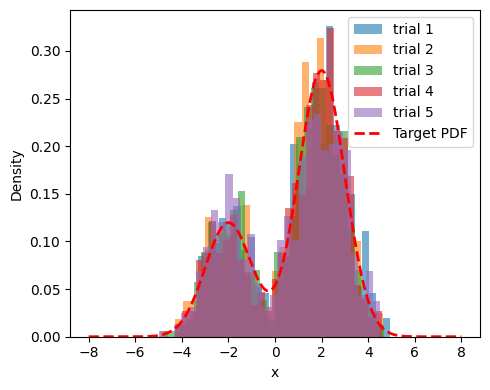

In [9]:
# run 
all_samples = []
all_acc_rates = []

for run in range(5):
    hmc = HMC(
        neg_log_prob=target.neg_log_pdf,
        num_dim=1,
        step_size=0.1,
        leapfrog_steps=20,
        num_samples=500,
        burn_in=50
    )
    samples, acc_rate = hmc.sample(init_position=None)
    samples = samples.view(-1).numpy()
    print(f"Run {run+1} - Acceptance Rate: {acc_rate:.4f}")
    all_samples.append(samples)
    all_acc_rates.append(acc_rate)
# plot the 
x_range = (-8, 8)
fig, ax = plt.subplots(figsize=(5, 4))

# Histogram of each run
for i, samples in enumerate(all_samples):
    ax.hist(samples, bins=30, density=True, alpha=0.6, label=f'trial {i+1}')
x_plot = torch.linspace(*x_range, 1000)
ax.plot(x_plot.numpy(), target.pdf(x_plot).numpy(), 'r--', lw=2, label='Target PDF')
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.legend()
plt.tight_layout()
plt.show()


## What happens when HMC meets Neural network?

In [10]:
## Define  a one-dimensional problem 
torch.manual_seed(0)  # fix the seed
def cubic_sin(x: torch.Tensor,
              noise_std: float = 0.1) -> torch.Tensor:
    """dis continuous function with noise"""

    obj = torch.sin(6*x)**3 + torch.randn_like(x) * noise_std

    return obj.reshape((-1, 1))
# get the training samples
sample_x1 = torch.linspace(-0.8, -0.2, 16).reshape((-1, 1))
sample_x2 = torch.linspace(0.2, 0.8, 16).reshape((-1, 1))
sample_x = torch.cat([sample_x1, sample_x2], dim=0)
# scale the data
x_mean = sample_x.mean(); x_std = sample_x.std()
sample_x_scaled = (sample_x - x_mean) / x_std
# get the responses
sample_y = cubic_sin(sample_x, noise_std=0.1)
# scale the y
y_mean = sample_y.mean(); y_std = sample_y.std()
sample_y_scaled = (sample_y - y_mean) / y_std


In [11]:
# Define the BNN model
class BNN(nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return self.fc3(x)

def flatten_params(model):
    # flatten the params of neural network for sampling
    return torch.cat([p.view(-1) for p in model.parameters()])

def assign_params(model, flat_params):
    # assign parameter (sampled params) to nerual network
    idx = 0
    for p in model.parameters():
        numel = p.numel()
        p.data.copy_(flat_params[idx:idx+numel].view_as(p))
        idx += numel

In [12]:
class BNN_Posterior(nn.Module):
    def __init__(self, model, X, y, noise_std=1, prior_std=1.0):
        super(BNN_Posterior, self).__init__()
        self.model = model
        self.X = X
        self.y = y
        self.noise_std = noise_std
        self.prior_std = prior_std

    def forward(self, flat_params):
        assign_params(self.model, flat_params)
        y_pred = self.model(self.X)
        log_likelihood = -0.5 * torch.sum((self.y - y_pred)**2) / self.noise_std**2
        log_prior = -0.5 * torch.sum(flat_params**2) / self.prior_std**2
        return -log_likelihood -log_prior

In [13]:

# Define model and target
input_dim = 1
hidden_dim = 256
output_dim = 1
model = BNN(input_dim, hidden_dim, output_dim)
neg_log_posterior = BNN_Posterior(model,
                    sample_x_scaled,
                    sample_y_scaled, noise_std=0.1/y_std.item(), prior_std=1.0)
param_dim = sum(p.numel() for p in model.parameters())
init_params = flatten_params(model).detach()


In [14]:
# count the number of parameters
print(f'Number of parameters in the model: {param_dim}')

Number of parameters in the model: 66561


In [15]:
# Run HMC sampling, play with those parameters
hmc = HMC(neg_log_posterior,
          num_dim=param_dim,
          step_size=0.001,
          leapfrog_steps=20,
          num_samples=1000, 
          burn_in=500)
samples, acc_rate = hmc.sample(init_position=init_params)

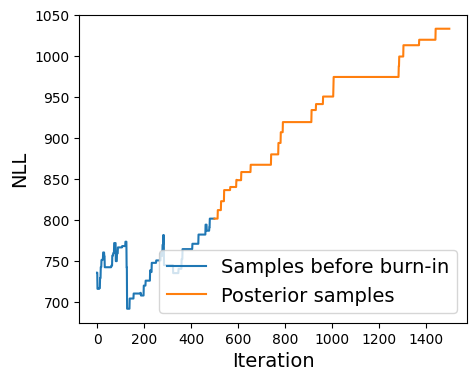

In [16]:

# plot the nll of whole samples 
plt.figure(figsize=(5,4))
plt.plot(np.arange(500), hmc.chain_nll[:500], label='Samples before burn-in')
plt.plot(np.arange(500, 1500), hmc.chain_nll[500:], label='Posterior samples')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('NLL', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [17]:
X_test = torch.linspace(-1, 1, 100).reshape((-1, 1))
y_test = cubic_sin(X_test, noise_std=0)  # ground truth
# scale the test data
X_test_scaled = (X_test - x_mean) / x_std
preds = []
for theta in samples: 
    assign_params(model, torch.tensor(theta, dtype=torch.float32))
    with torch.no_grad():
        pred = model(X_test_scaled)
        # scale the prediction back
        pred = pred * y_std + y_mean
        preds.append(pred.numpy())
preds = np.stack(preds) 
mean_pred = preds.mean(axis=0)
std_pred = preds.std(axis=0)

/tmp/ipykernel_18829/2799921095.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  assign_params(model, torch.tensor(theta, dtype=torch.float32))


In [18]:
def plot_prediction():
    # plot the predictions
    fig, ax = plt.subplots(figsize=(5, 4))

    ax.plot(X_test.numpy(), y_test.numpy(), '--', linewidth=2, color='gray',label='True Function')
    ax.plot(X_test.numpy(), pred,  linewidth=2, color="blue", label='Predicted Mean')
    ax.fill_between(X_test.numpy().flatten(),
                    pred.flatten() - 2 * np.sqrt(std_pred.flatten()),
                    pred.flatten() + 2 * np.sqrt(std_pred.flatten()),
                    color="blue",
                     edgecolor=None,
                      alpha=0.2,  linewidth=2, label='Epistemic Uncertainty')
    # scale the training data
    ax.scatter(sample_x, 
            sample_y, 
            color="red", marker='o', s=40, label='Training Data')
    # set the ticks and labels
    ax.set_xticks(np.arange(-1, 1.1, 0.5))
    ax.set_yticks(np.arange(-3, 2.1, 1.0))
    # set the font size
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    # set the labels
    ax.set_xlabel('x', fontsize=14)
    ax.set_ylabel('y', fontsize=14)
    plt.legend(fontsize=12, loc='lower left')
    # save the figure
    # set pad
    plt.tight_layout(pad=0.1)

    plt.show()

/tmp/ipykernel_18829/1428258882.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  pred.flatten() - 2 * np.sqrt(std_pred.flatten()),
/tmp/ipykernel_18829/1428258882.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  pred.flatten() + 2 * np.sqrt(std_pred.flatten()),


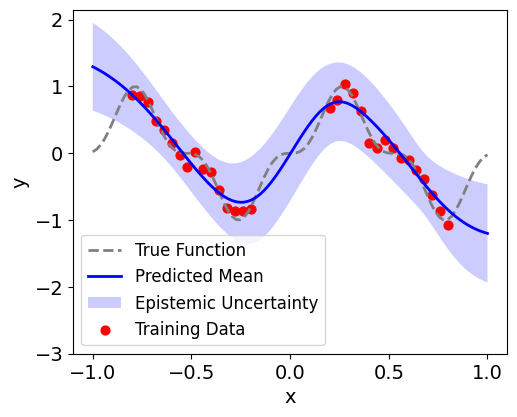

In [19]:
plot_prediction()

### See you next class

Have fun!